In [9]:
import cv2
import os
import tifffile as tiff
import numpy as np

# Archivo TIFF con la secuencia de frames
images_file = "./videos/MAX230426_bCatTracking_Exp91_20230426_73604 AM_f0009_t0000.tif"

# Archivo de detecciones generado por predict.py
detections_file = "output/MAX230426_bCatTracking_Exp91_20230426_73604 AM_f0009_t0000.txt"

# Carpeta de salida para imágenes con cuadros
output_dir = "output/visual/imagenes9"
os.makedirs(output_dir, exist_ok=True)

# Leer todos los frames del TIFF
frames_raw = tiff.imread(images_file)
frames = []

for i, f in enumerate(frames_raw):
    # Normalizar a 0-255
    f = ((f - f.min()) / (f.max() - f.min()) * 255).astype(np.uint8)
    
    # Asegurarse de que tenga 3 canales y en BGR para OpenCV
    if f.ndim == 2:  # gris
        f_bgr = np.stack([f]*3, axis=-1)
    elif f.ndim == 3 and f.shape[2] == 1:  # gris con canal extra
        f_bgr = np.concatenate([f]*3, axis=2)
    elif f.ndim == 3 and f.shape[2] == 3:  # RGB → BGR
        f_bgr = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
    else:
        raise ValueError(f"Frame {i} tiene un shape inesperado: {f.shape}")
    
    frames.append(f_bgr)

# Leer detecciones
detections = {}
with open(detections_file) as f:
    for line in f:
        frame_id, obj_id, x, y, w, h, conf, _, _ = map(float, line.strip().split(','))
        frame_id = int(frame_id)
        detections.setdefault(frame_id, []).append((x, y, w, h))

# Dibujar cajas y guardar imágenes
for frame_id, boxes in detections.items():
    if frame_id >= len(frames):
        print(f"Frame {frame_id} no existe en el TIFF")
        continue
    img = frames[frame_id].copy()
    for x, y, w, h in boxes:
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    output_path = os.path.join(output_dir, f"{frame_id:06d}.jpg")
    cv2.imwrite(output_path, img)

print("¡Listo! Imágenes guardadas en:", output_dir)


Frame 99 no existe en el TIFF
¡Listo! Imágenes guardadas en: output/visual/imagenes9


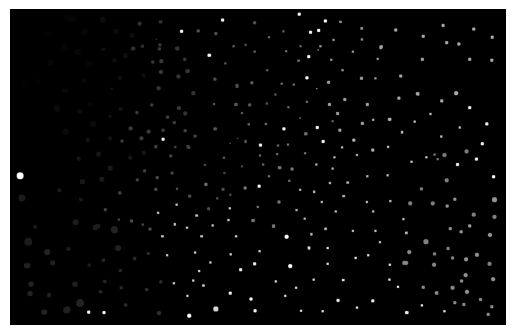

In [28]:
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import numpy as np

img = tiff.imread("../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02_GT/TRA/man_track091.tif")
cv2.imwrite("test_normalized.png", img)

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

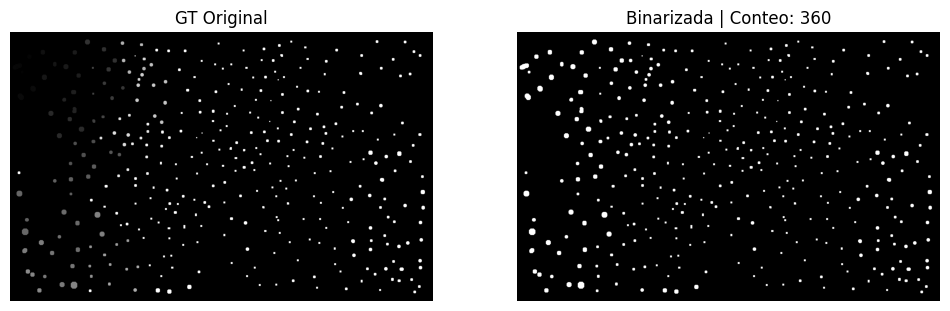

In [ ]:
import os
import glob
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label

#   Procesamiento de Ground Truth
def binarize_and_count(gt_path):
    """Carga GT, binariza todo >0 como célula y cuenta objetos."""
    img = tiff.imread(gt_path)

    if img.ndim == 3:
        img = img[0]

    # Convertir a rango visible sin alterar labels
    if img.dtype == np.uint16:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Binarización simple
    _, binary = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    # Conteo de objetos conectados
    num_labels = label(binary).max()
    return img, binary, num_labels

#   Visualizar imagenes
def visualize_gt(gt_path):
    original, binary, count = binarize_and_count(gt_path)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(original, cmap='gray')
    plt.title('GT Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(binary, cmap='gray')
    plt.title(f'Binarizada | Conteo: {count}')
    plt.axis('off')

    plt.show()

if __name__ == "__main__":
    gt_dir = "../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02_GT/TRA"
    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*.tif")))

    # Imagen a probar
    visualize_gt(gt_files[80])


Loading checkpoint weights/edf\yolov3-3T3-ckpt.pth
Loading checkpoint weights/edf\yolov3-A-10-ckpt.pth
Loading checkpoint weights/edf\yolov3-A-549-ckpt.pth
Loading checkpoint weights/edf\yolov3-APM-ckpt.pth
Loading checkpoint weights/edf\yolov3-BPAE-ckpt.pth
Loading checkpoint weights/edf\yolov3-CRE-BAG2-ckpt.pth
Loading checkpoint weights/edf\yolov3-CT-ckpt.pth
Loading checkpoint weights/edf\yolov3-CV-1-ckpt.pth
Loading checkpoint weights/edf\yolov3-LLC-MK2-ckpt.pth
Loading checkpoint weights/edf\yolov3-MDBK-ckpt.pth
Loading checkpoint weights/edf\yolov3-MDOK-ckpt.pth
Loading checkpoint weights/edf\yolov3-OK-ckpt.pth
Loading checkpoint weights/edf\yolov3-PL1Ut-ckpt.pth
Loading checkpoint weights/edf\yolov3-RK-13-ckpt.pth
Loading checkpoint weights/edf\yolov3-U2O-S-ckpt.pth


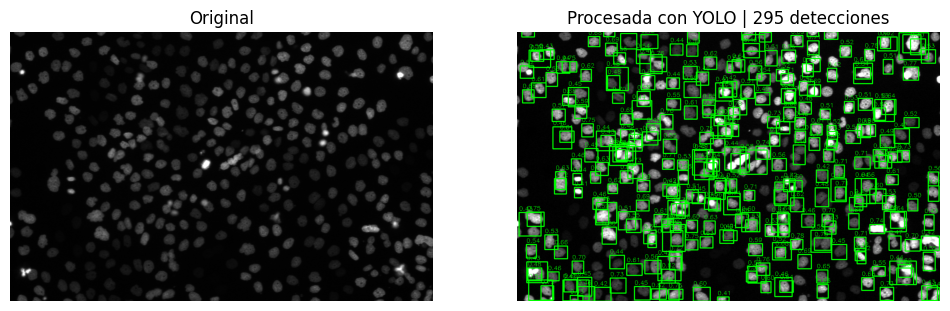

In [ ]:
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import numpy as np
import glob
import os
from edf import EDF

# Función de normalización para YOLO
def normalize_16bit_to_8bit(img):
    p1, p99 = np.percentile(img, (1, 99))
    img = np.clip(img, p1, p99)
    img = (img - img.min()) / (img.max() - img.min())
    return (img * 255).astype(np.uint8)

# Preprocesamiento como en pipeline de YOLO
def process_for_yolo(image_path):
    img_stack = tiff.imread(image_path)
    original = img_stack[0] if img_stack.ndim == 3 else img_stack
    img_norm = normalize_16bit_to_8bit(original) if original.dtype == np.uint16 else original.copy()
    img_yolo = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2BGR) if img_norm.ndim == 2 else img_norm.copy()
    return original, img_yolo

# Dibujar cuadros sobre la imagen
def draw_boxes(image, boxes):
    img_drawn = image.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        conf = box[4]
        cv2.rectangle(img_drawn, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_drawn, f'{conf:.2f}', (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return img_drawn

# Visualización de la imagen procesada con cuadros
def visualize_yolo_detection(image_path, model):
    original, processed = process_for_yolo(image_path)
    boxes = model(processed)
    img_with_boxes = draw_boxes(processed, boxes)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.imshow(original, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f'Procesada con YOLO | {len(boxes)} detecciones')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    data_dir = "../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02"
    image_files = sorted(glob.glob(os.path.join(data_dir, "*.tif")))

    model = EDF(
        'cfg/yolov3.cfg',
        'weights/edf',
        ensemble_option='affirmative',
        conf_threshold=0.4
    )

    # Visualizamos la imagen con los cuadros
    visualize_yolo_detection(image_files[12], model)


In [50]:
import os
import glob
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
from skimage.measure import label
from edf import EDF

#   Funciones de Ground Truth
def binarize_and_count(gt_path):
    """Carga GT, binariza todo >0 como célula y cuenta objetos."""
    img = tiff.imread(gt_path)

    if img.ndim == 3:
        img = img[0]  # GT a veces viene como stack

    if img.dtype == np.uint16:
        img = np.clip(img, 0, 255).astype(np.uint8)

    # Binarización simple
    _, binary = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    # Conteo de objetos conectados
    num_labels = label(binary).max()
    return img, binary, num_labels

#   Funciones para YOLO
def normalize_16bit_to_8bit(img):
    p1, p99 = np.percentile(img, (1, 99))
    img = np.clip(img, p1, p99)
    img = (img - img.min()) / (img.max() - img.min())
    return (img * 255).astype(np.uint8)

def process_for_yolo(image_path):
    img_stack = tiff.imread(image_path)
    original = img_stack[0] if img_stack.ndim == 3 else img_stack
    img_norm = normalize_16bit_to_8bit(original) if original.dtype == np.uint16 else original.copy()
    img_yolo = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2BGR) if img_norm.ndim == 2 else img_norm.copy()
    return original, img_yolo

def draw_boxes(image, boxes):
    img_drawn = image.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        conf = box[4]
        cv2.rectangle(img_drawn, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_drawn, f'{conf:.2f}', (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return img_drawn

#   Pipeline completo: EDF + GT + visualización + guardado
def process_and_save(image_path, gt_path, model, output_dir):
    # Procesamiento GT
    gt_original, gt_binary, gt_count = binarize_and_count(gt_path)

    # Procesamiento YOLO
    orig, processed = process_for_yolo(image_path)
    boxes = model(processed)
    img_yolo = draw_boxes(processed, boxes)

    # Combinar GT binarizado y YOLO en un mismo canvas
    canvas = np.zeros((orig.shape[0], orig.shape[1]*2, 3), dtype=np.uint8)

    # A la izquierda: GT binarizado
    gt_rgb = cv2.cvtColor(gt_binary, cv2.COLOR_GRAY2BGR)
    cv2.putText(gt_rgb, f'GT Count: {gt_count}', (10,20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    canvas[:, :orig.shape[1], :] = gt_rgb

    # A la derecha: YOLO detecciones
    cv2.putText(img_yolo, f'YOLO Det: {len(boxes)}', (10,20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
    canvas[:, orig.shape[1]:, :] = img_yolo

    # Guardar imagen final como JPG
    base_name = os.path.splitext(os.path.basename(image_path))[0] + ".jpg"
    save_path = os.path.join(output_dir, base_name)
    cv2.imwrite(save_path, canvas)

if __name__ == "__main__":
    # Directorios
    data_dir = "../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02"
    gt_dir = "../Fluo-N2DL-HeLa (1)/Fluo-N2DL-HeLa/02_GT/TRA"
    output_dir = "./output/visual/consensus-0.2"
    os.makedirs(output_dir, exist_ok=True)

    # Inicializar EDF
    model = EDF(
        'cfg/yolov3.cfg',
        'weights/edf',
        ensemble_option='consensus',
        conf_threshold=0.2
    )

    # Listar imágenes y GT
    image_files = sorted(glob.glob(os.path.join(data_dir, "*.tif")))
    gt_files = sorted(glob.glob(os.path.join(gt_dir, "*.tif")))

    # Procesar todas las imágenes
    for img_path, gt_path in zip(image_files, gt_files):
        print(f'Procesando {os.path.basename(img_path)}')
        process_and_save(img_path, gt_path, model, output_dir)

    print(f'Todas las imágenes guardadas en {output_dir}')


Loading checkpoint weights/edf\yolov3-3T3-ckpt.pth
Loading checkpoint weights/edf\yolov3-A-10-ckpt.pth
Loading checkpoint weights/edf\yolov3-A-549-ckpt.pth
Loading checkpoint weights/edf\yolov3-APM-ckpt.pth
Loading checkpoint weights/edf\yolov3-BPAE-ckpt.pth
Loading checkpoint weights/edf\yolov3-CRE-BAG2-ckpt.pth
Loading checkpoint weights/edf\yolov3-CT-ckpt.pth
Loading checkpoint weights/edf\yolov3-CV-1-ckpt.pth
Loading checkpoint weights/edf\yolov3-LLC-MK2-ckpt.pth
Loading checkpoint weights/edf\yolov3-MDBK-ckpt.pth
Loading checkpoint weights/edf\yolov3-MDOK-ckpt.pth
Loading checkpoint weights/edf\yolov3-OK-ckpt.pth
Loading checkpoint weights/edf\yolov3-PL1Ut-ckpt.pth
Loading checkpoint weights/edf\yolov3-RK-13-ckpt.pth
Loading checkpoint weights/edf\yolov3-U2O-S-ckpt.pth
Procesando t000.tif
Procesando t001.tif
Procesando t002.tif
Procesando t003.tif
Procesando t004.tif
Procesando t005.tif
Procesando t006.tif
Procesando t007.tif
Procesando t008.tif
Procesando t009.tif
Procesando t010